## Tracks data analysis

Let's assert tracks data analysis by taking a first inspection of the track dataset

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
from os import path
import numpy as np
import re
dataset_path = path.join('..', 'dataset', 'tracks.csv')
df = pd.read_csv(dataset_path, sep=',')

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11166 entries, 0 to 11165
Data columns (total 45 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    11166 non-null  object 
 1   id_artist             11166 non-null  object 
 2   name_artist           11166 non-null  object 
 3   full_title            11166 non-null  object 
 4   title                 11166 non-null  object 
 5   featured_artists      3517 non-null   object 
 6   primary_artist        11166 non-null  object 
 7   language              11061 non-null  object 
 8   album                 9652 non-null   object 
 9   stats_pageviews       4642 non-null   float64
 10  swear_IT              11166 non-null  int64  
 11  swear_EN              11166 non-null  int64  
 12  swear_IT_words        11166 non-null  object 
 13  swear_EN_words        11166 non-null  object 
 14  year                  10766 non-null  object 
 15  month              

year, month, day, n_sentence, n_tokens, disc_numer, track_number, popularity should all be Int64 (or at least float64: year and popularity are object), explicit should be bool

validation helper function checking expected types validity

In [3]:
def check_type_validity(value, expected_type):
    return not isinstance(value, expected_type)

### id

In [4]:
invalid_elems = df[df['id'].apply(check_type_validity, expected_type=str)]
print(invalid_elems['id'])

nan_indexes = df.index[df['id'].isna()].tolist()
print(f"number of missing values in id: {len(nan_indexes)}")

unique_ids = df['id'].nunique()
print(f"number of unique ids: {unique_ids}")

Series([], Name: id, dtype: object)
number of missing values in id: 0
number of unique ids: 11093


there are no missing id values in the dataset.
all the ids are strings with the following format "TR{unique_num_id}".
there are less unique ids than the number of rows (11093 < 11166), let's check if they come from duplicate songs or there are different songs with the same id

In [5]:
not_unique_ids = df['id'].value_counts()
not_unique_ids = not_unique_ids[not_unique_ids > 1]
print(f"there are {len(not_unique_ids)} not unique ids:")
print(not_unique_ids)

not_unique_ids_list = not_unique_ids.index.tolist()

identical_duplicates = []
different_duplicates = []
mixed_duplicates = [] #ids with both identical and different rows

for dup_id in not_unique_ids_list:
    duplicate_rows = df[df['id'] == dup_id]
    num_occurrences = len(duplicate_rows)
    
    unique_songs = duplicate_rows[['name_artist', 'title']].drop_duplicates()
    num_unique = len(unique_songs)

    if num_unique == 1:
        identical_duplicates.append(dup_id) #duplicate rows
    elif num_unique == num_occurrences:
        different_duplicates.append(dup_id) #different songs
    else:
        mixed_duplicates.append(dup_id) #duplicate rows and different songs

print(f"{len(identical_duplicates)} come from duplicate songs, ",
      f"{len(different_duplicates)} come from different songs with the same id, ",
      f"{len(mixed_duplicates)} have both duplicate and different songs")

there are 71 not unique ids:
id
TR367132    4
TR978886    2
TR987615    2
TR690925    2
TR772702    2
           ..
TR245683    2
TR903275    2
TR679972    2
TR247772    2
TR261964    2
Name: count, Length: 71, dtype: int64
0 come from duplicate songs,  70 come from different songs with the same id,  1 have both duplicate and different songs


of the 71 not unique ids, 70 refers to different songs, meaning that there are no duplicate songs respect to those ids, but there are ids which refers to multiple songs.

by analyzing more in depth the case with both duplicate and different songs:

In [6]:
for dup_id in mixed_duplicates: #iterating for a "general" solution, but in this case wouldn't be necessary
    duplicate_artist_song = df[df['id'] == dup_id]
    unique_songs = duplicate_artist_song[['name_artist', 'title']].drop_duplicates()
    print(f"for id {dup_id}, there are {len(unique_songs)} unique songs:")
    
    for idx, row in unique_songs.iterrows():
        song_rows = duplicate_artist_song[
            (duplicate_artist_song['name_artist'] == row['name_artist']) &
            (duplicate_artist_song['title'] == row['title'])]
        
        print(f"\t- '{row['title']}' by artist: {row['name_artist']}, occuring {len(song_rows)} times")
        
        if len(song_rows) != 1: #more than one occurrence
            first_row = song_rows.iloc[0]
            all_identical = True
            differing_columns = []

            for col in song_rows.columns:
                unique_values = song_rows[col].nunique()
                if unique_values > 1:
                    all_identical = False
                    differing_columns.append(col)
            
            if not all_identical:
                print(f"\t\tdiffering columns: {differing_columns}\n")
                
                #for col in differing_columns: #uncomment this for see values of different rows
                        #values = song_rows[col].tolist()
                        #print(f"\t\t• {col}:")
                        #for i, val in enumerate(values):
                            #print(f"\t\t\tRow {i+1}: {val}")

for id TR367132, there are 2 unique songs:
	- 'BUGIE' by artist: Madame, occuring 2 times
		differing columns: ['year', 'album_name', 'album_release_date', 'album_type', 'track_number', 'duration_ms', 'popularity', 'album_image', 'id_album']

	- '​sentimi' by artist: Madame, occuring 2 times
		differing columns: ['album_name', 'album_release_date', 'album_type', 'track_number', 'duration_ms', 'popularity', 'album_image', 'id_album']



so that id not only refers to 2 different songs, but each occurrence of the song (2) has different values. based on the values of different rows, it's possible to cut the additional wrong records

### id_artist

In [7]:
invalid_elems = df[df['id_artist'].apply(check_type_validity, expected_type=str)]
print(invalid_elems['id_artist'])

nan_indexes = df.index[df['id_artist'].isna()].tolist()
print(f"number of missing values in id_artist: {len(nan_indexes)}")

id_to_names = df.groupby('id_artist')['name_artist'].nunique()
multiple_names = id_to_names[id_to_names > 1]

if len(multiple_names) == 0:
    print("each id_artist corresponds to exactly one name_artist")

Series([], Name: id_artist, dtype: object)
number of missing values in id_artist: 0
each id_artist corresponds to exactly one name_artist


there are no missing id_artist values in the dataset. all the id_artists are strings with the following format "ART{unique_num_id}". each id_artist corresponds to exactly one name_artist

### name_artist

In [8]:
invalid_elems = df[df['name_artist'].apply(check_type_validity, expected_type=str)]
print(invalid_elems['name_artist'])

nan_indexes = df.index[df['name_artist'].isna()].tolist()
print(f"number of missing values in name_artist: {len(nan_indexes)}")

name_to_ids  = df.groupby('name_artist')['id_artist'].nunique()
multiple_ids  = name_to_ids [name_to_ids  > 1]

if len(multiple_names) == 0:
    print("each name_artist corresponds to exactly one id_artist")

Series([], Name: name_artist, dtype: object)
number of missing values in name_artist: 0
each name_artist corresponds to exactly one id_artist


there are no missing name_artist values in the dataset. all the name_artists are strings with the following format "ART{unique_num_id}". each name_artist corresponds to exactly one id_artist

### full_title

In [9]:
invalid_elems = df[df['full_title'].apply(check_type_validity, expected_type=str)]
print(invalid_elems['full_title'])

nan_indexes = df.index[df['full_title'].isna()].tolist()
print(f"number of missing values in full_title: {len(nan_indexes)}")

Series([], Name: full_title, dtype: object)
number of missing values in full_title: 0


there are no missing full_title values in the dataset. 
all the full_titles are strings with the following format: "{title} by {primary_artist} (Ft. {name_artist_1}, {...}, {name_artist_n-1} & {name_artist_n})". let's check if name_artist is inside every full title

In [10]:
#normalizing non-breaking space and quotes
df['full_title'] = (df['full_title']
                    .str.replace('\xa0', ' ', regex=False)    #non-breaking space
                    .str.replace('\u2019', "'", regex=False)  #right single quote
                    .str.replace('\u2018', "'", regex=False)  #left single quote
                    .str.replace('\u201c', '"', regex=False)  #left double quote
                    .str.replace('\u201d', '"', regex=False)) #right double quote

#(.+?) -> capture everything; (?:\s*\(|$) -> stop at either " (" or end of string
extracted_artist = df['full_title'].str.extract(r' by (.+?)(?:\s*\(|$)', expand=False).str.strip()

mismatches = df[extracted_artist != df['name_artist']]
print(f"number of name_artist mismatches inside full_title: {len(mismatches)}")

if len(mismatches) > 0:
    print("sample mismatches:")
    mismatches_display = mismatches.copy()
    mismatches_display['extracted_artist'] = extracted_artist[mismatches.index]
    display(mismatches_display[['full_title', 'name_artist', 'extracted_artist']].head(20))

number of name_artist mismatches inside full_title: 844
sample mismatches:


,full_title,name_artist,extracted_artist
36,"Mattonelle* by Rosa Chemical, Mehdi (ITA), Fri...",Rosa Chemical,"Rosa Chemical, Mehdi"
129,a me mi piace by Alfa & Manu Chao,Alfa,Alfa & Manu Chao
223,EGLI È IL RE by thasup & Mara Sattei,thasup,thasup & Mara Sattei
225,POSTO MIO by thasup & Mara Sattei,thasup,thasup & Mara Sattei
227,​r()t()nda by thasup & Tiziano Ferro,thasup,thasup & Tiziano Ferro
231,SO CHE CI SEI by thasup & Mara Sattei,thasup,thasup & Mara Sattei
235,BLESS SU BLESS by thasup & Mara Sattei,thasup,thasup & Mara Sattei
238,ONE KING by thasup & Mara Sattei,thasup,thasup & Mara Sattei
241,COME POLVERE by thasup & Mara Sattei,thasup,thasup & Mara Sattei
244,OCCHI MIEI by thasup & Mara Sattei,thasup,thasup & Mara Sattei


In [11]:
multi_artist_indicators = ['&', ',', ' and ']

has_separator = df['primary_artist'].str.contains('|'.join(multi_artist_indicators), case=False, na=False)
potential_multi = df[has_separator]

print(f"records with single artist: {len(df) - len(potential_multi)}")

records with single artist: 11166


The name_artist column contains only one artist per track, even when multiple artists collaborated (excluding featured artists), likely due to a data collection system limitation. while some tracks include non-rapper collaborators not in the dataset (e.g. Tiziano Ferro, Mara Sattei), which is expected, other tracks list only one rapper despite having multiple rapper collaborators who are present in the dataset (e.g. Ensi in Cemento). this causes artist-based analyses to undercount songs, as tracks where an artist collaborated but wasn't listed as the primary artist will be excluded from their catalog.

### title

In [12]:
invalid_elems = df[df['title'].apply(check_type_validity, expected_type=str)]
print(invalid_elems['title'])

nan_indexes = df.index[df['title'].isna()].tolist()
print(f"number of missing values in title: {len(nan_indexes)}")

Series([], Name: title, dtype: object)
number of missing values in title: 0


In [13]:
df['title'] = (df['title']
                .str.replace('\xa0', ' ', regex=False)
                .str.replace('\u2019', "'", regex=False)
                .str.replace('\u2018', "'", regex=False)
                .str.replace('\u201c', '"', regex=False)
                .str.replace('\u201d', '"', regex=False))

# ^(.+?) -> capture from start; \s+by\s+ -> stop at " by " (with flexible whitespace)
extracted_title = df['full_title'].str.extract(r'^(.+?)\s+by\s+', expand=False).str.strip()

mismatches = df[df['title'] != extracted_title]
print(f"number of title mismatches inside full_title: {len(mismatches)}")

if len(mismatches) > 0:
    print("remaining mismatches (likely titles containing 'by'):\n")
    mismatches_display = mismatches.copy()
    mismatches_display['extracted_title'] = extracted_title[mismatches.index]
    display(mismatches_display[['full_title', 'title', 'extracted_title']].head(10))

number of title mismatches inside full_title: 4
remaining mismatches (likely titles containing 'by'):



,full_title,title,extracted_title
2513,Bolo by Night RMX by Inoki,Bolo by Night RMX,Bolo
2578,Bolo by Night RMX (NewKingzTape) by Inoki (Ft....,Bolo by Night RMX (NewKingzTape),Bolo
2600,Bolo by Night (NewKingz RMX) by Inoki (Ft. Lil...,Bolo by Night (NewKingz RMX),Bolo
2642,Barona by Night (Red Bull Culture Clash dubpla...,Barona by Night (Red Bull Culture Clash dubplate),Barona


title is contained inside full_title with no errors. the missmatches appearing are titles containing the word 'by', which is what's used from the regex to split the string.

### featured_artists

In [14]:
invalid_elems = df[df['featured_artists'].apply(check_type_validity, expected_type=str)]
print(invalid_elems['featured_artists'])

nan_indexes = df.index[df['featured_artists'].isna()].tolist()
print(f"number of missing values in featured_artists: {len(nan_indexes)}")

5        NaN
6        NaN
8        NaN
9        NaN
10       NaN
        ... 
11159    NaN
11161    NaN
11163    NaN
11164    NaN
11165    NaN
Name: featured_artists, Length: 7649, dtype: object
number of missing values in featured_artists: 7649


this is expected, since not every track must have a featured artist. let's check if the featured artists of the column are the same listed in the full_title

In [15]:
df['featured_artists'] = (df['featured_artists']
                    .str.replace('\xa0', ' ', regex=False)
                    .str.replace('\u2019', "'", regex=False)
                    .str.replace('\u2018', "'", regex=False)
                    .str.replace('\u201c', '"', regex=False)
                    .str.replace('\u201d', '"', regex=False))

# \((?:Ft\.)\s*(.+?)\)\s*$ -> everything from "(Ft.)" until the closing ")"
extracted_featured = df['full_title'].str.extract(r'\((?:Ft\.)\s*(.+?)\)\s*$', expand=False).str.strip()
extracted_featured_normalized = extracted_featured.str.replace(' & ', ', ', regex=False)

def sort_splitted_by_comma(string):
    if pd.isna(string):
        return string
    ret = [a.strip() for a in string.split(',')]
    return ', '.join(sorted(ret))

extracted_sorted = extracted_featured_normalized.apply(sort_splitted_by_comma)
featured_sorted = df['featured_artists'].apply(sort_splitted_by_comma)

mismatches = df[
    ((extracted_sorted.notna()) & (featured_sorted.isna())) |
    ((extracted_sorted.isna()) & (featured_sorted.notna())) |
    ((extracted_sorted.notna()) & (featured_sorted.notna()) & (extracted_sorted != featured_sorted))
]

print(f"Rows with featured artists in full_title: {extracted_featured.notna().sum()}")
print(f"Rows with featured artists in column: {df['featured_artists'].notna().sum()}")
print(f"number of featured_artists mismatches (ignoring order): {len(mismatches)}\n")

if len(mismatches) > 0:
    print("Sample mismatches (actual differences, not just ordering):")
    mismatches_display = mismatches.copy()
    mismatches_display['featured_sorted'] = featured_sorted[mismatches.index]
    mismatches_display['extracted_sorted'] = extracted_sorted[mismatches.index]
    display(mismatches_display[['full_title', 'featured_sorted', 'extracted_sorted']].head(10))

Rows with featured artists in full_title: 3517
Rows with featured artists in column: 3517
number of featured_artists mismatches (ignoring order): 9

Sample mismatches (actual differences, not just ordering):


,full_title,featured_sorted,extracted_sorted
1566,Comunque vada... by Piotta (Ft. Turi & Compari),Turi & Compari,"Compari, Turi"
2427,Musica Vera by Mistaman (Ft. Stokka & MadBuddy),Stokka & MadBuddy,"MadBuddy, Stokka"
2461,Il giorno in cui ci siamo svegliati by Mistama...,Stokka & MadBuddy,"MadBuddy, Stokka"
2645,Lo Facciamo Così by Inoki (Ft. Stokka & MadBuddy),Stokka & MadBuddy,"MadBuddy, Stokka"
2844,Dreams by Johnny Marsiglia & Big Joe (Ft. Stok...,Stokka & MadBuddy,"MadBuddy, Stokka"
3301,Pace by Ghemon (Ft. Franco Negrè & Stokka & Ma...,"Franco Negrè, Stokka & MadBuddy","Franco Negrè, MadBuddy, Stokka"
3616,'O Sarracino by Neffa (Ft. Giuliano Palma & Th...,Giuliano Palma & The Bluebeaters,"Giuliano Palma, The Bluebeaters"
5576,CHIAGNE by Geolier (Ft. Lazza & Takagi & Ketra),"Lazza, Takagi & Ketra","Ketra, Lazza, Takagi"
9095,DONDURÈ by Dark Polo Gang (Ft. Ski & Wok),Ski & Wok,"Ski, Wok"


featured_artists is contained inside full_title with no errors. the missmatches are given from features made with group names including the character '&', which is what's used from the regex to split the string.

### primary_artist

In [16]:
invalid_elems = df[df['primary_artist'].apply(check_type_validity, expected_type=str)]
print(invalid_elems['primary_artist'])

nan_indexes = df.index[df['primary_artist'].isna()].tolist()
print(f"number of missing values in primary_artist: {len(nan_indexes)}")

Series([], Name: primary_artist, dtype: object)
number of missing values in primary_artist: 0


In [17]:
mismatches = df[df['primary_artist'] != df['name_artist']]
print(f"mismatches between name_artist and primary_artist: {len(mismatches)}")

if len(mismatches) > 0:
    display(mismatches[['id', 'full_title', 'name_artist', 'primary_artist']].head(5))

mismatches between name_artist and primary_artist: 0


there are no mismatches betweem this column and the name_artist column, so it doesn't add new informations. regarding the multiple primary_artists issue highlighted during the full_title analysis, it could be possible to both use this column to list all the primary artists (if more are present, and they are also present in the artist dataset), or cut this column and add more rows for the primary artists not present in name_artist but are present as artist and are present in the artist dataset.

### language

In [18]:
invalid_elems = df[df['language'].apply(check_type_validity, expected_type=str)]
print(invalid_elems['language'])

nan_indexes = df.index[df['language'].isna()].tolist()
print(f"number of missing values in language: {len(nan_indexes)}")

198      NaN
268      NaN
627      NaN
646      NaN
664      NaN
        ... 
8714     NaN
8757     NaN
8784     NaN
9086     NaN
10129    NaN
Name: language, Length: 105, dtype: object
number of missing values in language: 105


In [19]:
language_counts = df['language'].value_counts(dropna=False)

for i, (lang, count) in enumerate(language_counts.items(), 1):
    percentage = (count / len(df)) * 100
    lang_display = lang if pd.notna(lang) else "NaN (missing)"
    print(f"{i:3d}. {lang_display:13s} : {count:5d} tracks")

  1. it            :  9352 tracks
  2. en            :   843 tracks
  3. pl            :   588 tracks
  4. NaN (missing) :   105 tracks
  5. es            :    63 tracks
  6. co            :    48 tracks
  7. pt            :    45 tracks
  8. da            :    18 tracks
  9. cs            :    14 tracks
 10. fr            :    13 tracks
 11. nl            :     9 tracks
 12. sr            :     9 tracks
 13. war           :     9 tracks
 14. eu            :     8 tracks
 15. no            :     6 tracks
 16. ia            :     5 tracks
 17. ca            :     5 tracks
 18. gl            :     3 tracks
 19. de            :     2 tracks
 20. sco           :     2 tracks
 21. la            :     2 tracks
 22. eo            :     2 tracks
 23. rm            :     2 tracks
 24. et            :     1 tracks
 25. lt            :     1 tracks
 26. aa            :     1 tracks
 27. ro            :     1 tracks
 28. rw            :     1 tracks
 29. ru            :     1 tracks
 30. chr      

here are all the languages in the dataset. a lot of entries here are incorrect, and the criteria by which the language was assigned is not known. the following is a list of language codes that, upon manual inspection, actually correspond to Italian tracks: pl (Polish), da (Danish), cs (Czech), nl (Dutch), sr (Serbian), war (?), eu (?), no (?), ia (Interlingua), ca (Catalan), gl (Galician), sco (?), la (Latin), eo (Esperanto), rm (Romansh), et (Estonian), lt (Lithuanian), aa (?), ro (Romanian), rw (Kinyarwanda), chr (?), qu (Quechua), mt (Maltese), cy (Welsh), sq (Albanian), sw (Swahili)

In [20]:
incorrect_italian_codes = ['pl', 'da', 'cs', 'nl', 'sr', 'war', 'eu', 'no', 'ia', 'ca', 'gl', 'sco', 'la', 'eo', 'rm', 'et', 'lt', 'aa', 'ro', 'rw', 'chr', 'qu', 'mt', 'cy', 'sq', 'sw', 'co']
updated_rows = df[df['language'].isin(incorrect_italian_codes)]
print(f"updated rows: {len(updated_rows)}")

df.loc[df['language'].isin(incorrect_italian_codes), 'language'] = 'it'

language_counts = df['language'].value_counts(dropna=False)
for i, (lang, count) in enumerate(language_counts.items(), 1):
    percentage = (count / len(df)) * 100
    lang_display = lang if pd.notna(lang) else "NaN (missing)"
    print(f"{i:3d}. {lang_display:13s} : {count:5d} tracks")

updated rows: 741
  1. it            : 10093 tracks
  2. en            :   843 tracks
  3. NaN (missing) :   105 tracks
  4. es            :    63 tracks
  5. pt            :    45 tracks
  6. fr            :    13 tracks
  7. de            :     2 tracks
  8. ru            :     1 tracks
  9. bg            :     1 tracks


some (en (English), es (Spanish), pt (Portuguese), fr (French)) are mixed, co (Corsican) is basically italian (merged with 'it' as well), while the rest (de (German), ru (Russian), bg (Bulgarian)) are good. having this knowledge, i wouldn't rely much on this column for performing analysis

Ref. for languages code: https://www.cambridge.org/core/books/abs/interaction-of-borrowing-and-word-formation/list-of-iso639-language-codes/624C593339914D4A7DDA1AC55AC4889F

### album

In [21]:
invalid_elems = df[df['album'].apply(check_type_validity, expected_type=str)]
print(invalid_elems['album'])

nan_indexes = df.index[df['album'].isna()].tolist()
print(f"number of missing values in album: {len(nan_indexes)}")

10       NaN
21       NaN
22       NaN
23       NaN
24       NaN
        ... 
11156    NaN
11157    NaN
11159    NaN
11164    NaN
11165    NaN
Name: album, Length: 1514, dtype: object
number of missing values in album: 1514


this is expected, since not every track must be inside an album.

In [22]:
tracks_per_album = df['album'].value_counts()

print('top 20 albums with most tracks:')
for i, (album, count) in enumerate(tracks_per_album.head(20).items(), 1):
    print(f"{i:3d}. {album[:50]:50s} : {count:3d} tracks")

top 20 albums with most tracks:
  1. Rimo Da Quando                                     :  47 tracks
  2. TAXI DRIVER (Deluxe)                               :  37 tracks
  3. Solo Un Uomo (Gold Edition)                        :  36 tracks
  4. Il tempo vola 2002-2020                            :  36 tracks
  5. Di vizi di forma virtù                             :  35 tracks
  6. Cose Dell’Altro Mondo Mondo Marcio: Special Editio :  34 tracks
  7. SurreAle                                           :  30 tracks
  8. Status (Vendetta Edition)                          :  30 tracks
  9. DIO LO SA - ATTO II                                :  30 tracks
 10. Re Mida: Aurum                                     :  29 tracks
 11. The NewKingzTape Vol. 1                            :  29 tracks
 12. Miracolo! (Deluxe Edition)                         :  28 tracks
 13. ’A Verità 2.0                                      :  27 tracks
 14. Una cosetta così                                   :  26 tracks
 1

some albums list more tracks than they actually contain. my best guess is that a few standalone songs were mistakenly assigned to one of the artist’s albums.

### stats_pageviews

In [23]:
invalid_elems = df[df['stats_pageviews'].apply(check_type_validity, expected_type=int)]
print(invalid_elems['stats_pageviews'])

nan_indexes = df.index[df['stats_pageviews'].isna()].tolist()
print(f"number of missing values in stats_pageviews: {len(nan_indexes)}")

0        196033.0
1        164450.0
2         58313.0
3         39890.0
4         35432.0
           ...   
11161         NaN
11162         NaN
11163         NaN
11164         NaN
11165         NaN
Name: stats_pageviews, Length: 11166, dtype: float64
number of missing values in stats_pageviews: 6524


In [24]:
df['stats_pageviews'] = df['stats_pageviews'].astype('Int64')

invalid_elems = df[df['stats_pageviews'].apply(check_type_validity, expected_type=int)]
print(invalid_elems['stats_pageviews'])

nan_indexes = df.index[df['stats_pageviews'].isna()].tolist()
print(f"number of missing values in stats_pageviews: {len(nan_indexes)}")

0        196033
1        164450
2         58313
3         39890
4         35432
          ...  
11161      <NA>
11162      <NA>
11163      <NA>
11164      <NA>
11165      <NA>
Name: stats_pageviews, Length: 11166, dtype: Int64
number of missing values in stats_pageviews: 6524


converted stats_pageviews to Int64 (nullable integer, NaN shown as <NA>), since the values in the column are without a decimal point.

<Figure size 1400x600 with 0 Axes>

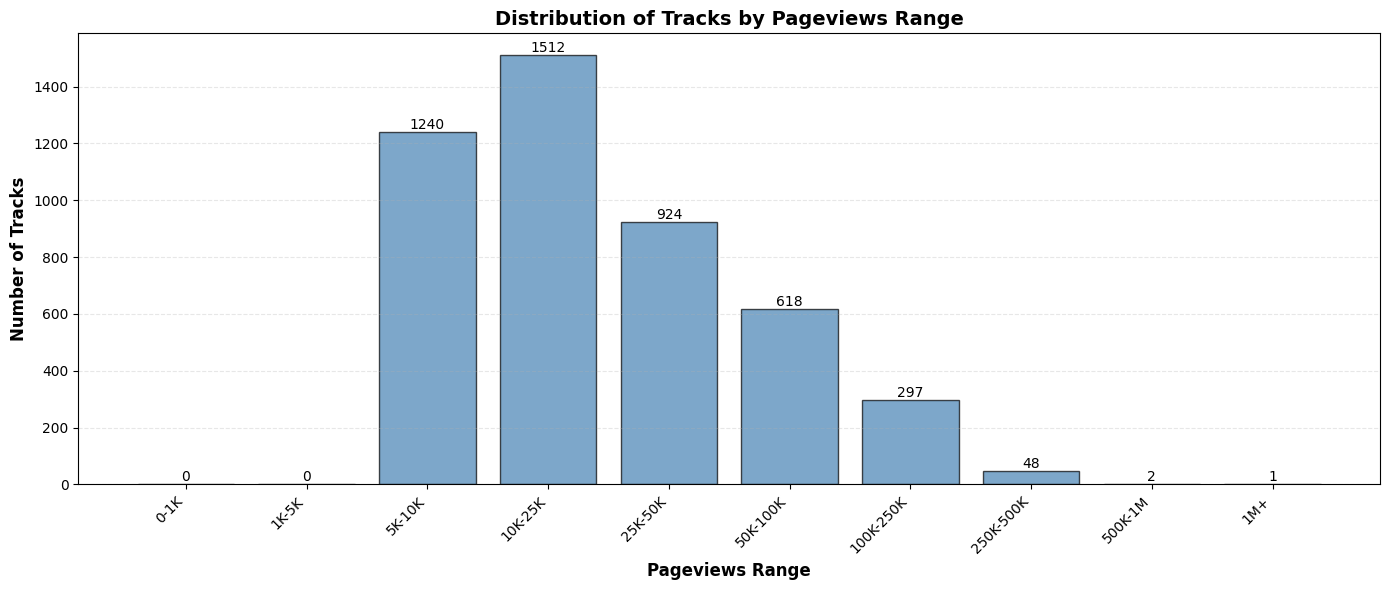

In [61]:
invalid_pageviews = df[(df['stats_pageviews'] < 0)]
if len(invalid_pageviews) > 0:
    print(f"{len(invalid_pageviews)} rows with invalid pageviews (negative values):")
    display(invalid_pageviews[['id', 'title', 'name_artist', 'stats_pageviews']].head(10))

plt.figure(figsize=(14, 6))

valid_pageviews = df['stats_pageviews'].dropna()

bins = [0, 1000, 5000, 10000, 25000, 50000, 100000, 250000, 500000, 1000000, np.inf]
labels = ['0-1K', '1K-5K', '5K-10K', '10K-25K', '25K-50K', '50K-100K', 
          '100K-250K', '250K-500K', '500K-1M', '1M+']

#categorize pageviews into bins
pageview_bins = pd.cut(valid_pageviews, bins=bins, labels=labels, include_lowest=True)
bin_counts = pageview_bins.value_counts().sort_index()

plt.figure(figsize=(14, 6))
plt.bar(range(len(bin_counts)), bin_counts.values, color='steelblue', edgecolor='black', alpha=0.7)
plt.xticks(range(len(bin_counts)), bin_counts.index, rotation=45, ha='right')
plt.xlabel('Pageviews Range', fontsize=12, fontweight='bold')
plt.ylabel('Number of Tracks', fontsize=12, fontweight='bold')
plt.title('Distribution of Tracks by Pageviews Range', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3, linestyle='--')

for i, v in enumerate(bin_counts.values):
    plt.text(i, v, str(v), ha='center', va='bottom', fontsize=10) #labels on bars

plt.tight_layout()
plt.show()

### swear_IT_words

In [25]:
invalid_elems = df[df['swear_IT_words'].apply(check_type_validity, expected_type=str)]
print(invalid_elems['swear_IT_words'])

nan_indexes = df.index[df['swear_IT_words'].isna()].tolist()
print(f"number of missing values in swear_IT_words: {len(nan_indexes)}")

Series([], Name: swear_IT_words, dtype: object)
number of missing values in swear_IT_words: 0


In [26]:
import ast

all_it_swear_words = set()

for value in df['swear_IT_words']:
    if pd.notna(value) and value != '[]':  #skip NaN and empty lists
        try:
            word_list = ast.literal_eval(value)
            all_it_swear_words.update(word_list)
        except:
            pass
        
print(all_it_swear_words)

{'minchiata', 'arrapato', 'merda', 'bastardi', 'tetta', 'blowjob', 'strafottenza', 'smerdare', 'peluria', 'cogliona', 'pippa', 'sputtanare', 'vagina', 'sedere', 'selvaggio', 'cozza', 'sboccare', 'coglione', 'pisciare', 'farabutti', 'spagnola', 'cesso', 'chiappa', 'fottersi', 'sgualdrina', 'jug', 'raspa', 'granchio', 'fellatio', 'stronzata', 'fesso', 'cacca', 'madonna', 'troiaio', 'arrapare', 'sega', 'toro', 'bischero', 'pisello', 'maiala', 'puttanaio', 'cazzata', 'merdina', 'escremento', 'cazzone', 'bernarda', 'fottio', 'zanzara', 'stupido', 'controcoglioni', 'scazzato', 'sborrare', 'sfigata', 'cagare', 'frocio', 'vaccata', 'cappella', 'handicappato', 'fortuna', 'zoccola', 'checca', 'farabutto', 'deretano', 'pugnetta', 'troia', 'cagna', 'fica', 'cazzo', 'mignotta', 'troiaggine', 'cornuto', 'cazzeggio', 'coglioni', 'fico', 'feci', 'gnocca', 'piccione', 'fottere', 'fregarsene', 'pipa', 'missionario', 'figa', 'vacca', 'sveltina', 'pompino', 'piscio', 'scassare', 'fregna', 'culo', 'schizza

there seems to be some english words among the italian swear words: "water, blowjob, jug"; "gay" is also english, but it doesn't appean in the swear_EN_words, so it was probably counted as an italian word. also there are words that are not swear words ("toro, fortuna, zanzara, granchio"), and other that are 'neutral' words ("pene, vagina, glutei, sedere, escremento, feci, peluria, selvaggio") but can sound vulgar in certain tracks. note that not all the swear words are taken into consideration, since some of them inside the lyrics can be a bit 'creative' (e.g. "apputtanamento")

In [27]:
it_words_to_exclude = ['water', 'blowjob', 'jug', 'toro', 'fortuna', 'zanzara', 'granchio']
filtered_it_swear_words = {word for word in all_it_swear_words if word not in it_words_to_exclude}

In [28]:
def find_swear_words_in_lyrics(lyrics, swear_words_list):
    if pd.isna(lyrics):
        return []

    lyrics_lower = lyrics.lower() #case-insensitive matching
    
    found_words = []
    for word in swear_words_list:
        pattern = r'\b' + re.escape(word) + r'\b'
        if re.search(pattern, lyrics_lower):
            found_words.append(word)
    
    return found_words
            
rows_changed = 0
rows_increased = 0
rows_decreased = 0
rows_both_changed = 0
rows_unchanged = 0
rows_processed = 0

for idx in df.index:
    lyrics = df.loc[idx, 'lyrics']
    
    found_words = find_swear_words_in_lyrics(lyrics, filtered_it_swear_words)
    new_words = set(found_words)
    
    old_value = df.loc[idx, 'swear_IT_words']
    
    #parse old swear words
    try:
        if pd.isna(old_value) or old_value == '[]':
            old_words = set()
        else:
            old_words = set(ast.literal_eval(old_value))
    except:
        old_words = set()
    
    new_value = str(found_words)
    df.loc[idx, 'swear_IT_words'] = new_value
    
    #track changes
    if old_words != new_words:
        rows_changed += 1
        
        words_added = new_words - old_words
        words_removed = old_words - new_words
        
        if words_added and words_removed:
            rows_both_changed += 1
        elif words_added:
            rows_increased += 1
        elif words_removed:
            rows_decreased += 1
    else:
        rows_unchanged += 1
    
    rows_processed += 1

print(f"unchanged rows: {rows_processed - rows_changed}")
print(f"rows where swear_IT_words was changed: {rows_changed}")

print(f"\t- words added only: {rows_increased}")
print(f"\t- words removed only: {rows_decreased}")
print(f"\t- both added and removed: {rows_both_changed}")

unchanged rows: 10659
rows where swear_IT_words was changed: 507
	- words added only: 0
	- words removed only: 507
	- both added and removed: 0


### swear_EN_words

In [29]:
invalid_elems = df[df['swear_EN_words'].apply(check_type_validity, expected_type=str)]
print(invalid_elems['swear_EN_words'])

nan_indexes = df.index[df['swear_EN_words'].isna()].tolist()
print(f"number of missing values in swear_EN_words: {len(nan_indexes)}")

Series([], Name: swear_EN_words, dtype: object)
number of missing values in swear_EN_words: 0


In [30]:
import ast

all_en_swear_words = set()

for value in df['swear_EN_words']:
    if pd.notna(value) and value != '[]':  #skip NaN and empty lists
        try:
            word_list = ast.literal_eval(value)
            all_en_swear_words.update(word_list)
        except:
            pass
        
print(all_en_swear_words)

{'slut', 'blowjob', 'tit', 'shibari', 'vagina', 'domination', 'hentai', 'poof', 'kinky', 'masturbation', 'tranny', 'faggot', 'cum', 'fellatio', 'butt', 'fag', 'coon', 'threesome', 'hardcore', 'cumming', 'clit', 'dildo', 'topless', 'sucks', 'pedobear', 'playboy', 'bastard', 'neonazi', 'tits', 'fuck', 'bondage', 'nipple', 'xxx', 'nympho', 'vulva', 'porno', 'semen', 'viagra', 'bitches', 'porn', 'pussy', 'sexo', 'nigga', 'xx', 'bullshit', 'raping', 'deepthroat', 'pissing', 'lolita', 'cocks', 'gangbang', 'bastardo', 'rape', 'spic', 'titty', 'milf', 'nude', 'snatch', 'anal', 'anus', 'rapist', 'ass', 'skeet', 'panties', 'doggystyle', 'horny', 'cialis', 'sex', 'creampie', 'suck', 'rimming', 'dick', 'bitch', 'fuckin', 'cunt', 'cumshot', 'ecchi', 'bbw', 'scat', 'fisting', 'hooker', 'escort', 'sexual', 'bukkake', 'sexy', 'motherfucker', 'shitty', 'shit', 'punany', 'fucking', 'cock', 'negro', 'voyeur', 'busty', 'asshole', 'boobs'}


there's an italian word "bastardo" among the english swear words. as in the italian set of swear words, there are words that aren't necessary swear words, but in certain tracks can be perceived as vulgar.

In [31]:
en_words_to_exclude = ['bastardo']
filtered_en_swear_words = {word for word in all_en_swear_words if word not in en_words_to_exclude}

In [32]:
rows_changed = 0
rows_increased = 0
rows_decreased = 0
rows_both_changed = 0
rows_unchanged = 0
rows_processed = 0

for idx in df.index:
    lyrics = df.loc[idx, 'lyrics']
    
    found_words = find_swear_words_in_lyrics(lyrics, filtered_en_swear_words)
    new_words = set(found_words)
    
    old_value = df.loc[idx, 'swear_EN_words']
    
    #parse old swear words
    try:
        if pd.isna(old_value) or old_value == '[]':
            old_words = set()
        else:
            old_words = set(ast.literal_eval(old_value))
    except:
        old_words = set()
    
    new_value = str(found_words)
    df.loc[idx, 'swear_EN_words'] = new_value
    
    #track changes
    if old_words != new_words:
        rows_changed += 1
        
        words_added = new_words - old_words
        words_removed = old_words - new_words
        
        if words_added and words_removed:
            rows_both_changed += 1
        elif words_added:
            rows_increased += 1
        elif words_removed:
            rows_decreased += 1
    else:
        rows_unchanged += 1
    
    rows_processed += 1

print(f"unchanged rows: {rows_processed - rows_changed}")
print(f"rows where swear_EN_words was changed: {rows_changed}")

print(f"\t- words added only: {rows_increased}")
print(f"\t- words removed only: {rows_decreased}")
print(f"\t- both added and removed: {rows_both_changed}")

unchanged rows: 10954
rows where swear_EN_words was changed: 212
	- words added only: 0
	- words removed only: 212
	- both added and removed: 0


### swear_IT

In [33]:
invalid_elems = df[df['swear_IT'].apply(check_type_validity, expected_type=int)]
print(invalid_elems['swear_IT'])

nan_indexes = df.index[df['swear_IT'].isna()].tolist()
print(f"number of missing values in swear_IT: {len(nan_indexes)}")

Series([], Name: swear_IT, dtype: int64)
number of missing values in swear_IT: 0


In [34]:
def count_swear_words_in_lyrics(lyrics, swear_words_list):
    if pd.isna(lyrics):
        return 0
    
    lyrics_lower = lyrics.lower()
    total_count = 0
    
    for word in swear_words_list:
        pattern = r'\b' + re.escape(word) + r'\b'
        matches = re.findall(pattern, lyrics_lower)
        total_count += len(matches)
    
    return total_count

rows_processed = 0
rows_changed = 0

for idx in df.index:
    lyrics = df.loc[idx, 'lyrics']
    old_count = df.loc[idx, 'swear_IT']
    
    swear_words_value = df.loc[idx, 'swear_IT_words']
    
    try:
        if pd.isna(swear_words_value) or swear_words_value == '[]':
            words_to_count = []
        else:
            words_to_count = ast.literal_eval(swear_words_value)
    except:
        words_to_count = []
    
    new_count = count_swear_words_in_lyrics(lyrics, words_to_count)
    
    df.loc[idx, 'swear_IT'] = new_count
    
    if old_count != new_count:
        rows_changed += 1
    
    rows_processed += 1
    
print(f"unchanged rows: {rows_processed - rows_changed}")
print(f"rows where swear_IT_words was updated: {rows_changed}")

unchanged rows: 10659
rows where swear_IT_words was updated: 507


### swear_EN

In [35]:
invalid_elems = df[df['swear_EN'].apply(check_type_validity, expected_type=int)]
print(invalid_elems['swear_EN'])

nan_indexes = df.index[df['swear_EN'].isna()].tolist()
print(f"number of missing values in swear_EN: {len(nan_indexes)}")

Series([], Name: swear_EN, dtype: int64)
number of missing values in swear_EN: 0


In [36]:
rows_processed = 0
rows_changed = 0

for idx in df.index:
    lyrics = df.loc[idx, 'lyrics']
    old_count = df.loc[idx, 'swear_EN']
    
    swear_words_value = df.loc[idx, 'swear_EN_words']
    
    try:
        if pd.isna(swear_words_value) or swear_words_value == '[]':
            words_to_count = []
        else:
            words_to_count = ast.literal_eval(swear_words_value)
    except:
        words_to_count = []
    
    new_count = count_swear_words_in_lyrics(lyrics, words_to_count)
    
    df.loc[idx, 'swear_EN'] = new_count
    
    if old_count != new_count:
        rows_changed += 1
    
    rows_processed += 1
    
print(f"unchanged rows: {rows_processed - rows_changed}")
print(f"rows where swear_EN_words was updated: {rows_changed}")

unchanged rows: 10954
rows where swear_EN_words was updated: 212


### year

In [37]:
invalid_elems = df[df['year'].apply(check_type_validity, expected_type=int)]
print(invalid_elems['year'])

nan_indexes = df.index[df['year'].isna()].tolist()
print(f"number of missing values in year: {len(nan_indexes)}")

0        2021.0
1        2020.0
2        2021.0
3        2019.0
4        2020.0
          ...  
11161       NaN
11162    2015.0
11163       NaN
11164    2005.0
11165       NaN
Name: year, Length: 11166, dtype: object
number of missing values in year: 400


In [38]:
non_numeric = df[pd.to_numeric(df['year'], errors='coerce').isna() & df['year'].notna()]
print(f"non-numeric year values ({len(non_numeric)}):")
print(non_numeric['year'].unique())

df['year'] = pd.to_numeric(df['year'], errors='coerce').astype('Int64')

invalid_elems = df[df['year'].apply(check_type_validity, expected_type=int)]
print(invalid_elems['year'])

nan_indexes = df.index[df['year'].isna()].tolist()
print(f"number of missing values in year: {len(nan_indexes)}")

non-numeric year values (38):
['nPmvFS' 'MoKKcY' 'PdLLvs' 'Tr5ghq' 'FZM9N5' '3KBIhx' '7arrc9' '0S4bYq'
 'Ww2RM0' 'YDWvPA' 'v9Gs4k' '1uWHmg' 's7ujOB' 'CeZdpY' 'DkWnRx' 'oiiWuy'
 'IlHfzv' 'uUsYUb' 'unxIUH' 'iW9Q9J' 'td0lg8' 'fNBiFf' 'RqnJ7g' 'VwVFFX'
 'Ise7dm' 'vgGgkT' 'QPNIJj' 'BMMnal' 'k2QnmQ' '6R1q9L' 'P03Hkq' 'tMcdp6'
 'epqCR2' 'Tl2Dgz' 'uiux8t' 'gZ2JDM' 'Gv70wC' '8i0piY']
0        2021
1        2020
2        2021
3        2019
4        2020
         ... 
11161    <NA>
11162    2015
11163    <NA>
11164    2005
11165    <NA>
Name: year, Length: 11166, dtype: Int64
number of missing values in year: 438


found 2153 rows with invalid years (< 1973 or > 2025):


,id,title,name_artist,year
6,TR170793,LOBBY WAY,Rosa Chemical,2072
7,TR627195,SLATT,Rosa Chemical,2098
22,TR634516,Freestyle #redbullnext #essemagazine,Rosa Chemical,1917
29,TR242610,Sono Io !!,Rosa Chemical,1920
34,TR344681,ALIENO,Rosa Chemical,1901
35,TR945862,Teschio,Rosa Chemical,2052
48,TR225367,TIPO DI N,Rosa Chemical,2081
53,TR904495,Dovreicomprarmiunacollanacomeimigos,Rosa Chemical,2060
58,TR440692,LATTE +,Rosa Chemical,1933
59,TR141416,I need some sleep (Intro),Rosa Chemical,1928


(array([1875., 1900., 1925., 1950., 1975., 2000., 2025., 2050., 2075.,
        2100., 2125.]),
 [Text(1875.0, 0, '1875'),
  Text(1900.0, 0, '1900'),
  Text(1925.0, 0, '1925'),
  Text(1950.0, 0, '1950'),
  Text(1975.0, 0, '1975'),
  Text(2000.0, 0, '2000'),
  Text(2025.0, 0, '2025'),
  Text(2050.0, 0, '2050'),
  Text(2075.0, 0, '2075'),
  Text(2100.0, 0, '2100'),
  Text(2125.0, 0, '2125')])

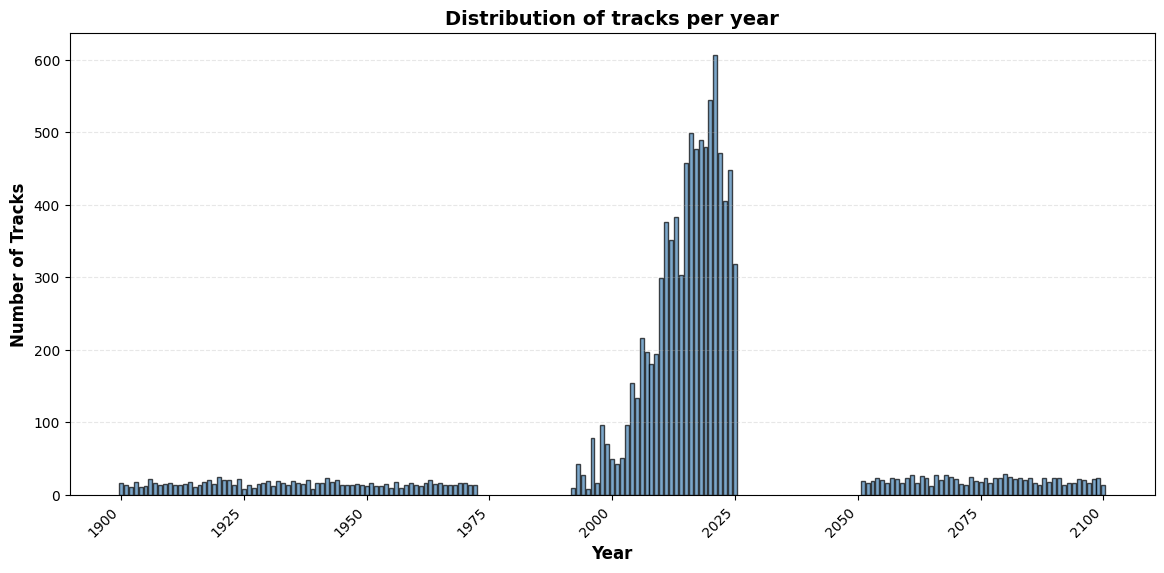

In [39]:
invalid_years = df[(df['year'] < 1973) | (df['year'] > 2025)]

if len(invalid_years) > 0:
    print(f"found {len(invalid_years)} rows with invalid years (< 1973 or > 2025):")
    display(invalid_years[['id', 'title', 'name_artist', 'year']].head(10))
    
year_counts = df['year'].value_counts().sort_index()

plt.figure(figsize=(14, 6))
plt.bar(year_counts.index, year_counts.values, color='steelblue', edgecolor='black', alpha=0.7)

plt.xlabel('Year', fontsize=12, fontweight='bold')
plt.ylabel('Number of Tracks', fontsize=12, fontweight='bold')
plt.title('Distribution of tracks per year', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3, linestyle='--')

plt.xticks(rotation=45, ha='right')

there seems to be a lot of invalid years. the ones above the year 2025 are for obvious reasons wrong, but the ones below 1973 might be really old tracks. let's check this by using the lowest active_start field of the artists.csv dataset

In [40]:
artists_path = path.join('..', 'dataset', 'artists.csv')
df_artists = pd.read_csv(artists_path, sep=';')

df_artists['active_start'] = pd.to_datetime(df_artists['active_start'], errors='coerce')
missing_count = df_artists['active_start'].isna().sum()
print(f"missing active_start values: {missing_count}")

earliest_date = df_artists['active_start'].min()
print(f"earliest active_start: {earliest_date}")

missing active_start values: 54
earliest active_start: 1988-01-01 00:00:00


by checking them, we can notice that are there are no artist in the dataset with such low year of active_start. there might be one in the missing active_start values that is lower, but by checking some of the tracks with release year below 1973, i can say with enough confidence that those are all invalid years.

### month

In [41]:
invalid_elems = df[df['month'].apply(check_type_validity, expected_type=int)]
print(invalid_elems['month'])

nan_indexes = df.index[df['month'].isna()].tolist()
print(f"number of missing values in month: {len(nan_indexes)}")

0         4.0
1         3.0
2         2.0
3         3.0
4         5.0
         ... 
11161     NaN
11162    11.0
11163     NaN
11164     1.0
11165     NaN
Name: month, Length: 11166, dtype: float64
number of missing values in month: 1197


In [42]:
df['month'] = pd.to_numeric(df['month'], errors='coerce').astype('Int64')

invalid_elems = df[df['month'].apply(check_type_validity, expected_type=int)]
print(invalid_elems['month'])

nan_indexes = df.index[df['month'].isna()].tolist()
print(f"number of missing values in month: {len(nan_indexes)}")

0           4
1           3
2           2
3           3
4           5
         ... 
11161    <NA>
11162      11
11163    <NA>
11164       1
11165    <NA>
Name: month, Length: 11166, dtype: Int64
number of missing values in month: 1197


In [43]:
invalid_months = df[(df['month'] < 1) | (df['month'] > 12)]

if len(invalid_months) > 0:
    print(f"found {len(invalid_years)} rows with invalid month (< 1 or > 12):")
    display(invalid_months[['id', 'title', 'name_artist', 'month']].head(10))

even though all the months have valid values, a lot of them are missing

### day

In [44]:
invalid_elems = df[df['day'].apply(check_type_validity, expected_type=int)]
print(invalid_elems['day'])

nan_indexes = df.index[df['day'].isna()].tolist()
print(f"number of missing values in day: {len(nan_indexes)}")

0         2.0
1         6.0
2        19.0
3         8.0
4        29.0
         ... 
11161     NaN
11162     9.0
11163     NaN
11164     1.0
11165     NaN
Name: day, Length: 11166, dtype: float64
number of missing values in day: 1323


In [45]:
df['day'] = pd.to_numeric(df['day'], errors='coerce').astype('Int64')

invalid_elems = df[df['day'].apply(check_type_validity, expected_type=int)]
print(invalid_elems['day'])

nan_indexes = df.index[df['day'].isna()].tolist()
print(f"number of missing values in day: {len(nan_indexes)}")

0           2
1           6
2          19
3           8
4          29
         ... 
11161    <NA>
11162       9
11163    <NA>
11164       1
11165    <NA>
Name: day, Length: 11166, dtype: Int64
number of missing values in day: 1323


### n_sentences

In [46]:
invalid_elems = df[df['n_sentences'].apply(check_type_validity, expected_type=int)]
print(invalid_elems['n_sentences'])

nan_indexes = df.index[df['n_sentences'].isna()].tolist()
print(f"number of missing values in n_sentences: {len(nan_indexes)}")

0        102.0
1         56.0
2         88.0
3         37.0
4         48.0
         ...  
11161     75.0
11162     76.0
11163     74.0
11164     32.0
11165     45.0
Name: n_sentences, Length: 11166, dtype: float64
number of missing values in n_sentences: 76


In [47]:
df['n_sentences'] = pd.to_numeric(df['n_sentences'], errors='coerce').astype('Int64')

def count_sentences_in_lyrics(lyrics):
    if pd.isna(lyrics):
        return 0
    lines = lyrics.split('\n')
    count = sum(1 for line in lines if line.strip())
    return count

def count_empty_lines(lyrics):
    if pd.isna(lyrics):
        return 0
    lines = lyrics.split('\n')
    return sum(1 for line in lines if not line.strip())

def count_total_lines(lyrics):
    if pd.isna(lyrics):
        return 0
    return len(lyrics.split('\n'))

computed_sentences = df['lyrics'].apply(count_sentences_in_lyrics)
empty_lines = df['lyrics'].apply(count_empty_lines)
total_lines = df['lyrics'].apply(count_total_lines)

mismatches_sentences = df[df['n_sentences'] != computed_sentences]

print(f"matching rows: {len(df) - len(mismatches_sentences)}")
print(f"mismatching rows: {len(mismatches_sentences)}\n")

comparison_display = pd.DataFrame({
    'title': df['title'],
    'stored_n_sentences': df['n_sentences'],
    'computed_non_empty': computed_sentences,
    'empty_lines': empty_lines,
    'total_lines': total_lines,
    'diff': computed_sentences - df['n_sentences']
})
display(comparison_display.head(10))

matching rows: 4768
mismatching rows: 6398



,title,stored_n_sentences,computed_non_empty,empty_lines,total_lines,diff
0,​polka 2 :-/,102,98,5,103,-4
1,POLKA,56,56,5,61,0
2,​britney ;-),88,87,7,94,-1
3,CEO,37,37,4,41,0
4,LONDRA,48,48,6,54,0
5,BOHEME,62,62,8,70,0
6,LOBBY WAY,82,80,6,86,-2
7,SLATT,82,77,8,85,-5
8,MADE IN ITALY,82,82,8,90,0
9,ROSE & ROVI,50,49,3,52,-1


from those results my guess is that the number of sentences is counted from the number of new lines in the lyrics. the results seems to be inconsistent: some of the songs also count the empty lines, while others don't

 ### n_tokens

In [48]:
invalid_elems = df[df['n_tokens'].apply(check_type_validity, expected_type=int)]
print(invalid_elems['n_tokens'])

nan_indexes = df.index[df['n_tokens'].isna()].tolist()
print(f"number of missing values in n_tokens: {len(nan_indexes)}")

0        911.0
1        675.0
2        758.0
3        382.0
4        429.0
         ...  
11161    624.0
11162    602.0
11163    570.0
11164    304.0
11165    338.0
Name: n_tokens, Length: 11166, dtype: float64
number of missing values in n_tokens: 76


In [49]:
df['n_tokens'] = pd.to_numeric(df['n_tokens'], errors='coerce').astype('Int64')

def count_words(lyrics):
    if pd.isna(lyrics):
        return 0
    return len(lyrics.split()) #split by whitespace

computed_words = df['lyrics'].apply(count_words)

matches_words = (df['n_tokens'] == computed_words).sum()
matching_tracks = df[computed_words == df['n_tokens']].copy()
diff_words = computed_words - df['n_tokens']

print(f"matches: {matches_words}")
print(f"mean difference: {diff_words.mean():+.2f}")

print(f"\nsome matching tracks:")
display_cols = ['title', 'n_tokens', 'lyrics']
display(matching_tracks[display_cols].head(20))

matches: 88
mean difference: -79.56

some matching tracks:


,title,n_tokens,lyrics
58,LATTE +,4,1 ContributorLATTE + Lyrics
65,C. A. S.,5,1 ContributorC. A. S. Lyrics
279,Night Cherry,4,8 ContributorsNight Cherry Lyrics
641,Escamotage,8,Biggie Paul sopra il beat sta in alto
645,2P solo,4,4 Contributors2P solo Lyrics
1575,Overture,3,3 ContributorsOverture Lyrics
1623,Incompatibile - Strumentale,9,1 ContributorIncompatibile - Strumentale Lyric...
1626,La Valigia - Strumentale,10,1 ContributorLa Valigia - Strumentale LyricsTh...
1982,Intro,12,La Pina\nPina\nLa Pina\nPina\nLa Pina\nPina\nL...
2671,Nobiltà Di Strada (Intro),4,Inoki\nNobiltà di strada


the number of tokens doesn't seem to count the tokens only by splitting by whitespace. From the mean difference, we can notice that there are missing tokens that are not getting counted. By analyzing some of the lyrics, all seem to have in common to be short (mostly errors) and with no punctuation, so i'll try to include it in the token count

In [50]:
def count_tokens_split_punctuation(lyrics):
    if pd.isna(lyrics):
        return 0
    import re
    #split on word boundaries - keeps alphanumeric sequences separate from punctuation
    # \w+ -> word characters (letters, numbers); [^\w\s] ->  punctuation (not words and not separators);
    tokens = re.findall(r'\w+|[^\w\s]', lyrics)
    return len(tokens)

computed_split_punct = df['lyrics'].apply(count_tokens_split_punctuation)

matches_words = (df['n_tokens'] == computed_split_punct).sum()
matching_tracks = df[computed_split_punct == df['n_tokens']].copy()
diff_words = computed_split_punct - df['n_tokens']

print(f"matches: {matches_words}")
print(f"mean difference: {diff_words.mean():+.2f}")

print(f"\nsome matching tracks:")
display_cols = ['title', 'n_tokens', 'lyrics']
display(matching_tracks[display_cols].head(20))

matches: 561
mean difference: +3.50

some matching tracks:


,title,n_tokens,lyrics
50,Blackout,241,"Chiusi dentro una stanza senza guardare l'ora,..."
58,LATTE +,4,1 ContributorLATTE + Lyrics
61,Punk 'a Piana,6,2 ContributorsPunk ’a Piana Lyrics
62,Ritratti dell'odio,805,"Kranyo, ah, vai\n\nMi siedo e ripenso ""Mah, st..."
68,Luciano Pavarotty // Glock,7,1 ContributorLuciano Pavarotty // Glock Lyrics
82,Chicas,333,Tutte matte le mie amiche\nTutte matte le mie ...
113,Mood Blu,396,"Tra tutte le scuse che mi racconto, mi circond..."
153,CI SARÒ,386,"Voglio guadagnarmi da vivere, ma non vivere pe..."
167,non so chi ha creato il mondo,45,Questa donna che riflette il cielo\nChe fa azz...
176,WNDLST Freestyle,219,"Eh, okay\nNon sono uno che parla tanto, ma sto..."


this produces a result similar to the one in the dataset (with even long songs matching), but it's hard to say which are the chars that counted as tokens and which are not.

### tokens_per_sent

In [51]:
invalid_elems = df[df['tokens_per_sent'].apply(check_type_validity, expected_type=int)]
print(invalid_elems['tokens_per_sent'])

nan_indexes = df.index[df['tokens_per_sent'].isna()].tolist()
print(f"number of missing values in tokens_per_sent: {len(nan_indexes)}")

0         8.931373
1        12.053571
2         8.613636
3        10.324324
4         8.937500
           ...    
11161     8.320000
11162     7.921053
11163     7.702703
11164     9.500000
11165     7.511111
Name: tokens_per_sent, Length: 11166, dtype: float64
number of missing values in tokens_per_sent: 76


In [52]:
expected_tokens_per_sent = df['n_tokens'] / df['n_sentences']

tolerance = 1e-6
matches = (abs(df['tokens_per_sent'] - expected_tokens_per_sent) <= tolerance) | (df['tokens_per_sent'].isna() & expected_tokens_per_sent.isna())

total_rows = len(df)
num_matches = matches.sum()
num_mismatches = total_rows - num_matches

print(f"Matching rows (correct n_tokens over n_sentences): {num_matches}")
print(f"Mismatching rows: {num_mismatches}")

Matching rows (correct n_tokens over n_sentences): 11166
Mismatching rows: 0


this column is correctly computed, the 76 missing values are given by the missing 76 values of n_tokens and n_sentences.